In [1]:
import pandas as pd
import os

In [3]:
dir_nmi    ='/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/nmi_output_test/'
dir_nmi_nl ='/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/nmi_nonlinear_output/'
dir_nmi_l  ='/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/nmi_linear_output/'
dir_te_x_y ='/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/te_x_y_output/'
dir_te_y_x ='/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/te_y_x_output/'


In [4]:
def combined_csv(data_dir):
    datasets = ['obs', 'merra', 'era', 'clm', 'amip']
    pairs = {
        'swc_rad': ('swc', 'rad'),
        'swc_le':  ('swc', 'le'),
        'swc_sh':  ('swc', 'sh'),
        'swc_gh':  ('swc', 'gh'),
        'rad_le':  ('rad', 'le'),
        'rad_sh':  ('rad', 'sh'),
        'rad_gh':  ('rad', 'gh'),
        'le_sh':   ('le', 'sh'),
        'le_gh':   ('le', 'gh'),
        'sh_gh':   ('sh', 'gh'),
    }

    results_out = {ds: {} for ds in datasets}

    for dataset in datasets:
        for pair_name, (var1, var2) in pairs.items():
            filename1 = f"{dataset}_{var1}_{var2}.csv"
            filename2 = f"{dataset}_{var2}_{var1}.csv"
            path1 = os.path.join(data_dir, filename1)
            path2 = os.path.join(data_dir, filename2)

            if os.path.exists(path1):
                df = pd.read_csv(path1,na_values=-9999)
            elif os.path.exists(path2):
                df = pd.read_csv(path2,na_values=-9999)
            else:
                print(f"⚠️ Missing: {filename1} or {filename2}")
                continue

            results_out[dataset][pair_name] = df
            # print(f"✅ Loaded: {dataset} - {pair_name}")

    return results_out


In [5]:
nmi   = combined_csv(dir_nmi)
nmi_nl   = combined_csv(dir_nmi_nl)
nmi_l   = combined_csv(dir_nmi_l)
te_x_y   = combined_csv(dir_te_x_y)
te_y_x   = combined_csv(dir_te_y_x)

In [6]:
def elementwise_percent_reduction(nmi_l_dict, nmi_nl_dict):
    """
    total = (1 - nmi_nl/mi) * 100 를 데이터셋/페어별로 원소단위 계산.
    반환: (total_dict, missing_pairs)
    """
    out = {}
    missing = []  # nmi_nl에 없는 (dataset, pair) 기록

    for ds, pairs in nmi_l_dict.items():
        out[ds] = {}
        for pair, df_mi in pairs.items():
            df_nl = nmi_nl_dict.get(ds, {}).get(pair)
            if df_nl is None:
                missing.append((ds, pair))
                continue

            # 인덱스와 컬럼을 교집합으로 정렬(모양 달라도 안전)
            df_l2, df_nl2 = df_l.align(df_nl, join='inner', axis=None)

            if (df_l2 < df_nl2):
                df_l2 = 0.
#             # 0으로 나누기 방지
#             denom = df_mi2.replace(0, np.nan)

#             # 원소별 계산
#             res = (1 - (df_nl2 / denom)) * 100.0
            
#             # if clamp:
#             #     # 음수는 0으로, 필요하면 100 초과도 100으로
#             res = res.clip(lower=0, upper=None)   # upper=100 도 가능
                
            out[ds][pair] = df_l2

    return out, missing

# 사용 예시
# mi      = combined_csv(dir_mi)
# nmi_nl  = combined_csv(dir_nmi_nl)
nmi, missing = elementwise_percent_reduction(nmi_l, nmi_nl)

NameError: name 'df_l' is not defined

In [8]:
def compute_summary(corr_dict):
    summary_dict = {}
    for pair_name, df in corr_dict.items():
        # Compute quartiles and median for each column and create a summary DataFrame.
        summary_df = pd.DataFrame({'Q1': df.quantile(0.25),
                                    'median': df.median(),
                                    'Q3': df.quantile(0.75)}).T  # Transpose so that the index is ['Q1', 'median', 'Q3'].
        summary_dict[pair_name] = summary_df
    return summary_dict

In [9]:
obs_nmi_summary      = compute_summary(nmi['obs'])
era_nmi_summary      = compute_summary(nmi['era'])
merra_nmi_summary    = compute_summary(nmi['merra'])
clm_nmi_summary      = compute_summary(nmi['clm'])
amip_nmi_summary     = compute_summary(nmi['amip'])

obs_nmi_nl_summary   = compute_summary(nmi_nl['obs'])
era_nmi_nl_summary   = compute_summary(nmi_nl['era'])
merra_nmi_nl_summary = compute_summary(nmi_nl['merra'])
clm_nmi_nl_summary   = compute_summary(nmi_nl['clm'])
amip_nmi_nl_summary  = compute_summary(nmi_nl['amip'])

obs_nmi_l_summary    = compute_summary(nmi_l['obs'])
era_nmi_l_summary    = compute_summary(nmi_l['era'])
merra_nmi_l_summary  = compute_summary(nmi_l['merra'])
clm_nmi_l_summary    = compute_summary(nmi_l['clm'])
amip_nmi_l_summary   = compute_summary(nmi_l['amip'])

obs_te_x_y_summary   = compute_summary(te_x_y['obs'])
era_te_x_y_summary   = compute_summary(te_x_y['era'])
merra_te_x_y_summary = compute_summary(te_x_y['merra'])
clm_te_x_y_summary   = compute_summary(te_x_y['clm'])
amip_te_x_y_summary  = compute_summary(te_x_y['amip'])

obs_te_y_x_summary   = compute_summary(te_y_x['obs'])
era_te_y_x_summary   = compute_summary(te_y_x['era'])
merra_te_y_x_summary = compute_summary(te_y_x['merra'])
clm_te_y_x_summary   = compute_summary(te_y_x['clm'])
amip_te_y_x_summary  = compute_summary(te_y_x['amip'])

In [10]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties

In [31]:
def plot_selected_monthly_evolution(
    obs_nmi_summary   ,era_nmi_summary   ,merra_nmi_summary   ,clm_nmi_summary   ,amip_nmi_summary,
    obs_nmi_nl_summary,era_nmi_nl_summary,merra_nmi_nl_summary,clm_nmi_nl_summary,amip_nmi_nl_summary,
    obs_nmi_l_summary ,era_nmi_l_summary ,merra_nmi_l_summary ,clm_nmi_l_summary ,amip_nmi_l_summary
    ):
    
    selected_keys = ['swc_rad', 'swc_le', 'swc_sh', 'swc_gh']
    titles = ['(a) [SWC, Rn]','(b) [SWC, LE]','(c) [SWC, SH]','(d) [SWC, GH]']
    n_cols = len(selected_keys)
    n_rows = 3  # 1st row: corr, 2nd row: MI

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 10), sharex=True)

    months = np.arange(1, 13)

    for j, key in enumerate(selected_keys):
        # First row: NMI
        ax_nmi = axes[0, j]
        if key in obs_nmi_summary:
            ax_nmi.plot(months, obs_nmi_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_nmi_summary:
            ax_nmi.plot(months, era_nmi_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_nmi_summary:
            ax_nmi.plot(months, merra_nmi_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_nmi_summary:
            ax_nmi.plot(months, clm_nmi_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_nmi_summary:
            ax_nmi.plot(months, amip_nmi_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_nmi.set_ylim(0.0, 0.45)
        ax_nmi.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax_nmi.set_title(titles[j], fontsize=20, loc='left')
        ax_nmi.set_xticks(months)
        ax_nmi.set_xlim(0.5, 12.5)
        ax_nmi.grid(True)
        ax_nmi.tick_params(axis="both", which="major", labelsize=15)
        if j == 0:
            ax_nmi.set_ylabel("NMI", fontsize=20)


        # Second row: Mutual Information
        ax_nmi_l = axes[1, j]
        if key in obs_nmi_l_summary:
            ax_nmi_l.plot(months, obs_nmi_l_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_nmi_l_summary:
            ax_nmi_l.plot(months, era_nmi_l_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_nmi_l_summary:
            ax_nmi_l.plot(months, merra_nmi_l_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_nmi_l_summary:
            ax_nmi_l.plot(months, clm_nmi_l_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_nmi_l_summary:
            ax_nmi_l.plot(months, amip_nmi_l_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_nmi_l.set_ylim(0.0, 0.45)
        ax_nmi_l.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

        ax_nmi_l.set_xticks(months)
        ax_nmi_l.set_xlim(0.5, 12.5)
        ax_nmi_l.grid(True)
        ax_nmi_l.tick_params(axis="both", which="major", labelsize=15)
        if j == 0:
            ax_nmi_l.set_ylabel("Linear", fontsize=20)

        # Second row: Mutual Information
        ax_nmi_nl = axes[2, j]
        if key in obs_nmi_nl_summary:
            ax_nmi_nl.plot(months, obs_nmi_nl_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_nmi_nl_summary:
            ax_nmi_nl.plot(months, era_nmi_nl_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_nmi_nl_summary:
            ax_nmi_nl.plot(months, merra_nmi_nl_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_nmi_nl_summary:
            ax_nmi_nl.plot(months, clm_nmi_nl_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_nmi_nl_summary:
            ax_nmi_nl.plot(months, amip_nmi_nl_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_nmi_nl.set_ylim(0.0, 0.45)
        ax_nmi_nl.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

        ax_nmi_nl.set_xticks(months)
        ax_nmi_nl.set_xlim(0.5, 12.5)
        ax_nmi_nl.grid(True)
        ax_nmi_nl.tick_params(axis="both", which="major", labelsize=15)
        if j == 0:
            ax_nmi_nl.set_ylabel("Non-linear", fontsize=20)
            
    # Legend
    handle_obs   = mlines.Line2D([], [], color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
    handle_merra = mlines.Line2D([], [], color='red', marker='s', linewidth=2, label='MERRA2')
    handle_era   = mlines.Line2D([], [], color='blue', marker='s', linewidth=2, label='ERA5')
    handle_clm   = mlines.Line2D([], [], color='green', marker='x', linewidth=2, label='CLM')
    handle_amip  = mlines.Line2D([], [], color='orange', marker='+', linewidth=2, label='CLM+CAM')

    bold_font = FontProperties(weight='bold', size=18)
    fig.legend(handles=[handle_obs,handle_merra,  handle_era, handle_clm, handle_amip],
               loc='upper center', framealpha=1, prop=bold_font, ncol=5, bbox_to_anchor=(0.5, 0.03))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


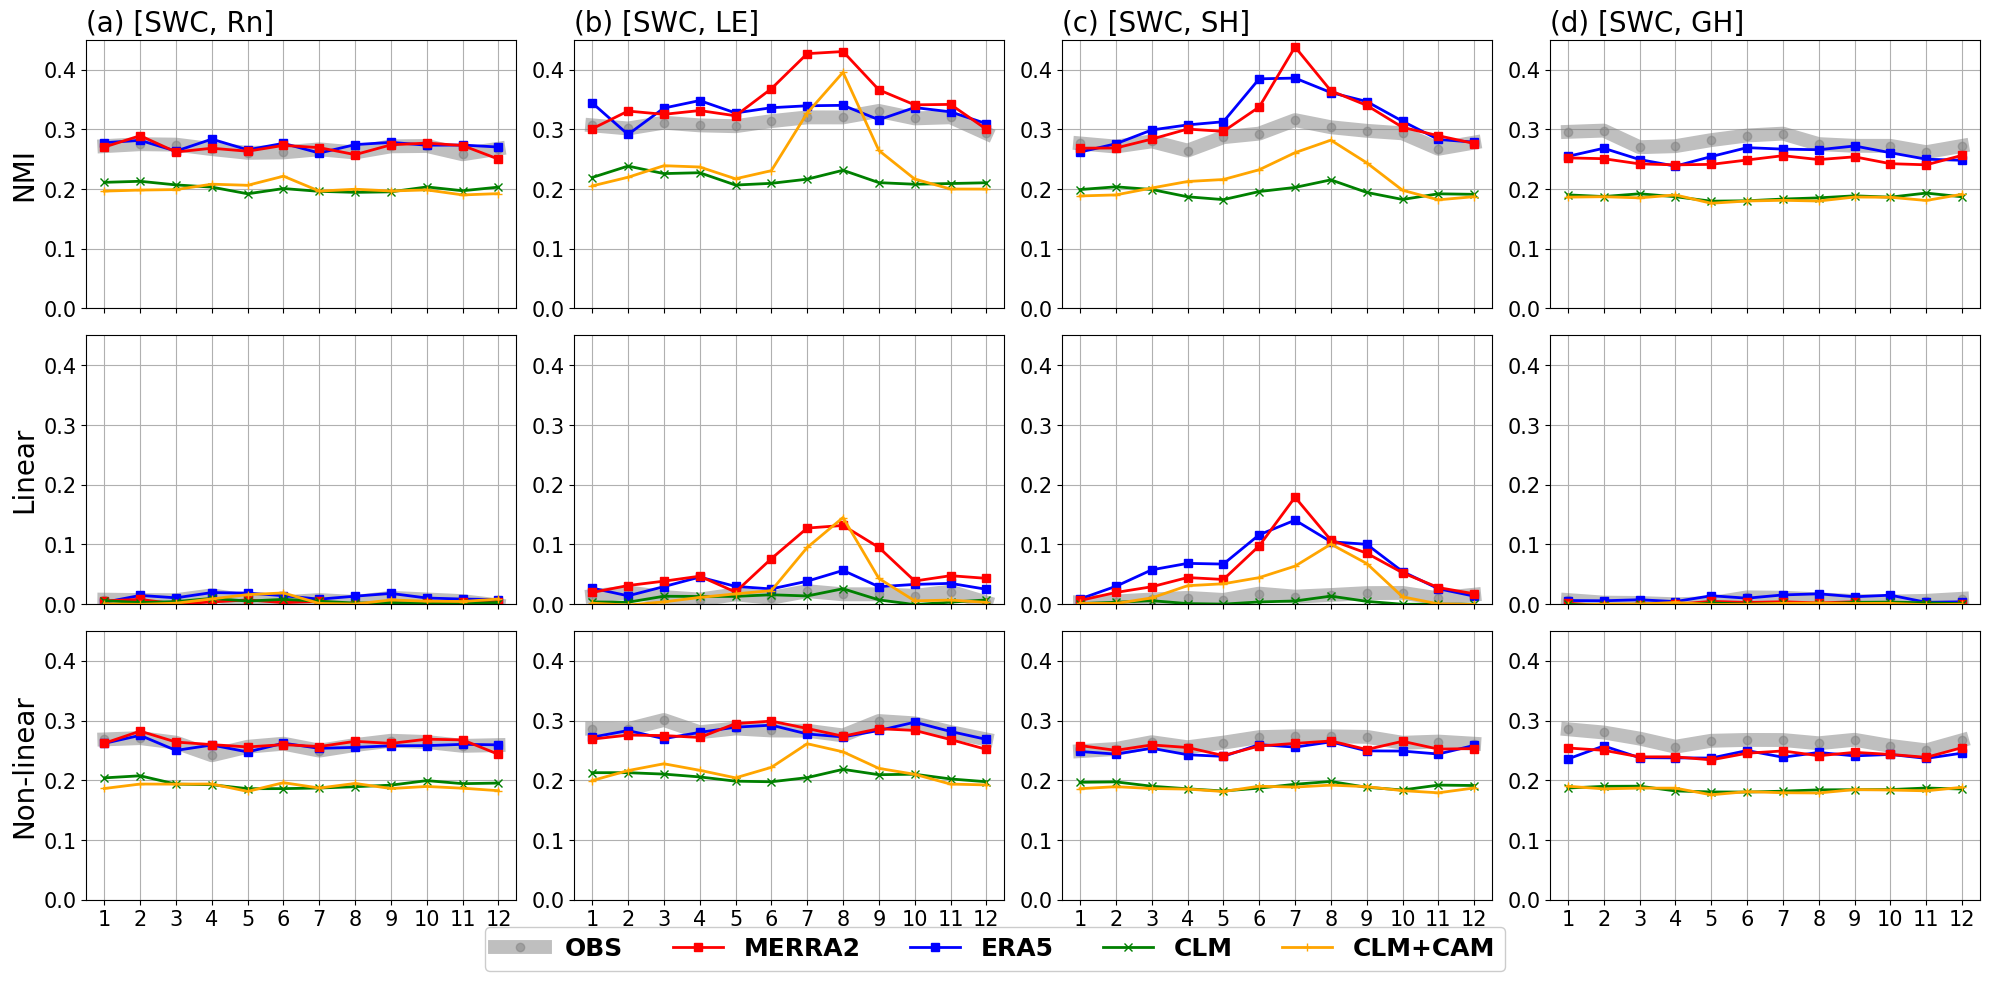

In [32]:
plot_selected_monthly_evolution(
    obs_nmi_summary   ,era_nmi_summary   ,merra_nmi_summary   ,clm_nmi_summary   ,amip_nmi_summary,
    obs_nmi_nl_summary,era_nmi_nl_summary,merra_nmi_nl_summary,clm_nmi_nl_summary,amip_nmi_nl_summary,
    obs_nmi_l_summary ,era_nmi_l_summary ,merra_nmi_l_summary ,clm_nmi_l_summary ,amip_nmi_l_summary
)


In [36]:
def plot_selected_monthly_evolution(obs_corr_summary, era_corr_summary, merra_corr_summary,
                                     clm_corr_summary, amip_corr_summary,
                                     obs_mi_summary, era_mi_summary, merra_mi_summary,
                                     clm_mi_summary, amip_mi_summary):
    
    selected_keys = ['swc_rad', 'swc_le', 'swc_sh', 'swc_gh']
    titles = ['(a) [SWC, Rn]','(b) [SWC, LE]','(c) [SWC, SH]','(d) [SWC, GH]']
    n_cols = len(selected_keys)
    n_rows = 2  # 1st row: corr, 2nd row: MI

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6), sharex=True)

    months = np.arange(1, 13)

    for j, key in enumerate(selected_keys):
        # First row: Correlation
        ax_corr = axes[0, j]
        if key in obs_corr_summary:
            ax_corr.plot(months, obs_corr_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_corr_summary:
            ax_corr.plot(months, era_corr_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_corr_summary:
            ax_corr.plot(months, merra_corr_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_corr_summary:
            ax_corr.plot(months, clm_corr_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_corr_summary:
            ax_corr.plot(months, amip_corr_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_corr.set_ylim(0, 0.35)
        # ax_corr.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax_corr.hlines(0, 0,13, color='black',alpha=0.7)
        ax_corr.set_title(titles[j], fontsize=20, loc='left')
        ax_corr.set_xticks(months)
        ax_corr.set_xlim(0.5, 12.5)
        ax_corr.tick_params(axis="both", which="major", labelsize=15)


        ax_corr.grid(True)
        if j == 0:
            ax_corr.set_ylabel("Linear", fontsize=20)

        # Second row: Mutual Information
        ax_mi = axes[1, j]
        if key in obs_mi_summary:
            ax_mi.plot(months, obs_mi_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_mi_summary:
            ax_mi.plot(months, era_mi_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_mi_summary:
            ax_mi.plot(months, merra_mi_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_mi_summary:
            ax_mi.plot(months, clm_mi_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_mi_summary:
            ax_mi.plot(months, amip_mi_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_mi.set_ylim(0.0, 0.35)
        ax_mi.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

        ax_mi.set_xticks(months)
        ax_mi.set_xlim(0.5, 12.5)
        ax_mi.grid(True)
        ax_mi.tick_params(axis="both", which="major", labelsize=15)
        if j == 0:
            ax_mi.set_ylabel("Non-linear", fontsize=20)

    # Legend
    handle_obs   = mlines.Line2D([], [], color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
    handle_merra = mlines.Line2D([], [], color='red', marker='s', linewidth=2, label='MERRA2')
    handle_era   = mlines.Line2D([], [], color='blue', marker='s', linewidth=2, label='ERA5')
    handle_clm   = mlines.Line2D([], [], color='green', marker='x', linewidth=2, label='CLM')
    handle_amip  = mlines.Line2D([], [], color='orange', marker='+', linewidth=2, label='CLM+CAM')

    bold_font = FontProperties(weight='bold', size=18)
    fig.legend(handles=[handle_obs,handle_merra,  handle_era, handle_clm, handle_amip],
               loc='upper center', framealpha=1, prop=bold_font, ncol=5, bbox_to_anchor=(0.5, 0.03))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


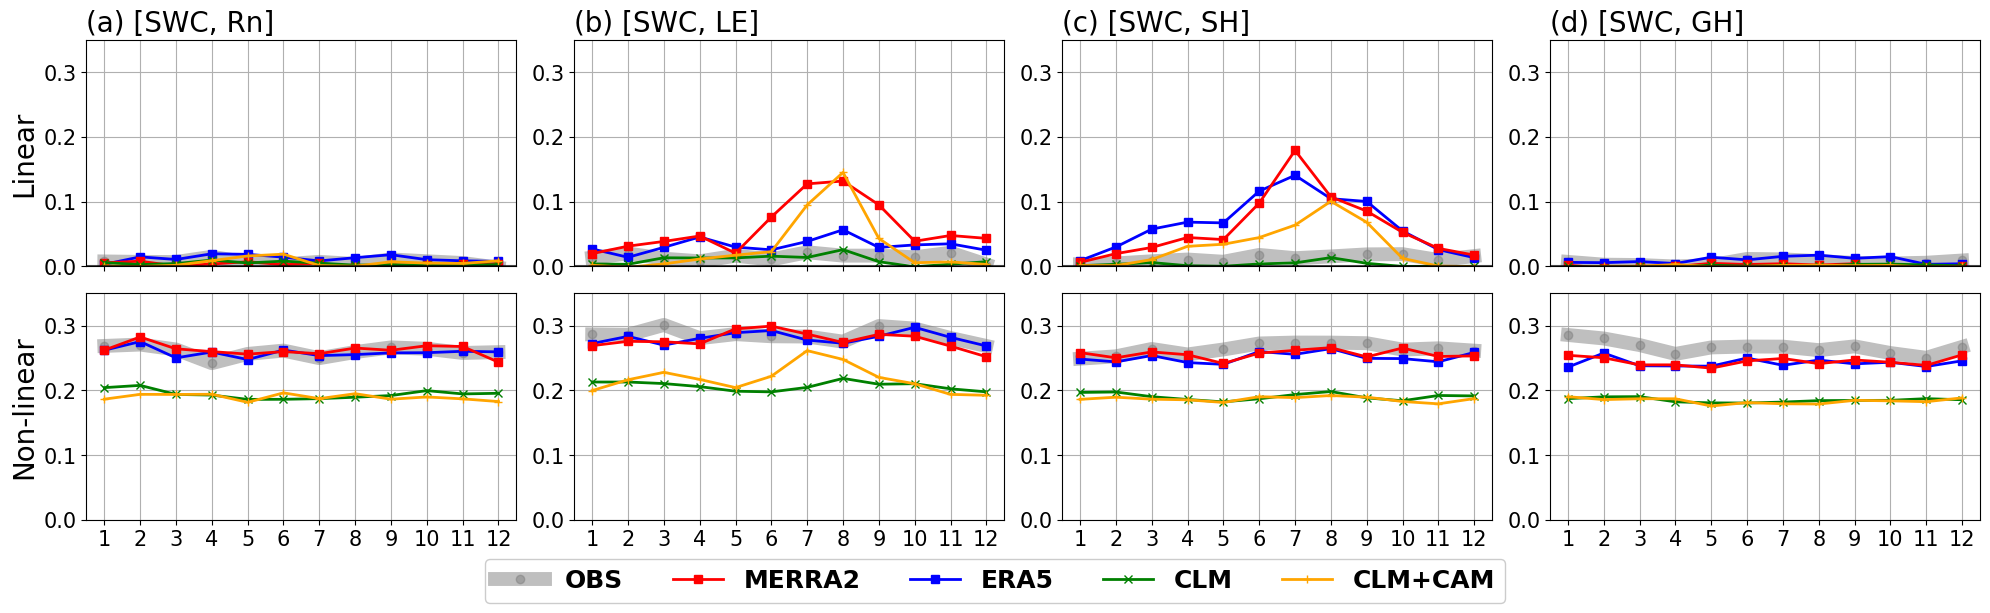

In [37]:
plot_selected_monthly_evolution(
    obs_nmi_l_summary ,era_nmi_l_summary ,merra_nmi_l_summary ,clm_nmi_l_summary ,amip_nmi_l_summary,
        obs_nmi_nl_summary,era_nmi_nl_summary,merra_nmi_nl_summary,clm_nmi_nl_summary,amip_nmi_nl_summary,

)

In [ ]:
def plot_TE_monthly_evolution(
    obs_nmi_summary   ,era_nmi_summary   ,merra_nmi_summary   ,clm_nmi_summary   ,amip_nmi_summary,
    obs_nmi_nl_summary,era_nmi_nl_summary,merra_nmi_nl_summary,clm_nmi_nl_summary,amip_nmi_nl_summary,
    obs_nmi_l_summary ,era_nmi_l_summary ,merra_nmi_l_summary ,clm_nmi_l_summary ,amip_nmi_l_summary
    ):
    
    selected_keys = ['swc_rad', 'swc_le', 'swc_sh', 'le_sh']
    titles = ['(a) [SWC, Rn]','(b) [SWC, LE]','(c) [SWC, SH]','(d) [LE, SH]']
    n_cols = len(selected_keys)
    n_rows = 3  # 1st row: corr, 2nd row: MI

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 10), sharex=True)

    months = np.arange(1, 13)

    for j, key in enumerate(selected_keys):
        # First row: NMI
        ax_nmi = axes[0, j]
        if key in obs_nmi_summary:
            ax_nmi.plot(months, obs_nmi_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_nmi_summary:
            ax_nmi.plot(months, era_nmi_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_nmi_summary:
            ax_nmi.plot(months, merra_nmi_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_nmi_summary:
            ax_nmi.plot(months, clm_nmi_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_nmi_summary:
            ax_nmi.plot(months, amip_nmi_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_nmi.set_ylim(0.0, 0.45)
        ax_nmi.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax_nmi.set_title(titles[j], fontsize=20, loc='left')
        ax_nmi.set_xticks(months)
        ax_nmi.set_xlim(0.5, 12.5)
        ax_nmi.grid(True)
        ax_nmi.tick_params(axis="both", which="major", labelsize=15)
        if j == 0:
            ax_nmi.set_ylabel("NMI", fontsize=20)


        # Second row: Mutual Information
        ax_nmi_l = axes[1, j]
        if key in obs_nmi_l_summary:
            ax_nmi_l.plot(months, obs_nmi_l_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_nmi_l_summary:
            ax_nmi_l.plot(months, era_nmi_l_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_nmi_l_summary:
            ax_nmi_l.plot(months, merra_nmi_l_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_nmi_l_summary:
            ax_nmi_l.plot(months, clm_nmi_l_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_nmi_l_summary:
            ax_nmi_l.plot(months, amip_nmi_l_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_nmi_l.set_ylim(0.3, 1.)
        ax_nmi_l.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

        ax_nmi_l.set_xticks(months)
        ax_nmi_l.set_xlim(0.5, 12.5)
        ax_nmi_l.grid(True)
        ax_nmi_l.tick_params(axis="both", which="major", labelsize=15)
        if j == 0:
            ax_nmi_l.set_ylabel("X -> Y", fontsize=20)

        # Second row: Mutual Information
        ax_nmi_nl = axes[2, j]
        if key in obs_nmi_nl_summary:
            ax_nmi_nl.plot(months, obs_nmi_nl_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_nmi_nl_summary:
            ax_nmi_nl.plot(months, era_nmi_nl_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_nmi_nl_summary:
            ax_nmi_nl.plot(months, merra_nmi_nl_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_nmi_nl_summary:
            ax_nmi_nl.plot(months, clm_nmi_nl_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_nmi_nl_summary:
            ax_nmi_nl.plot(months, amip_nmi_nl_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_nmi_nl.set_ylim(0.3, 1.)
        ax_nmi_nl.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

        ax_nmi_nl.set_xticks(months)
        ax_nmi_nl.set_xlim(0.5, 12.5)
        ax_nmi_nl.grid(True)
        ax_nmi_nl.tick_params(axis="both", which="major", labelsize=15)
        if j == 0:
            ax_nmi_nl.set_ylabel("Y -> X", fontsize=20)
            
    # Legend
    handle_obs   = mlines.Line2D([], [], color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
    handle_merra = mlines.Line2D([], [], color='red', marker='s', linewidth=2, label='MERRA2')
    handle_era   = mlines.Line2D([], [], color='blue', marker='s', linewidth=2, label='ERA5')
    handle_clm   = mlines.Line2D([], [], color='green', marker='x', linewidth=2, label='CLM')
    handle_amip  = mlines.Line2D([], [], color='orange', marker='+', linewidth=2, label='CLM+CESM2')

    bold_font = FontProperties(weight='bold', size=18)
    fig.legend(handles=[handle_obs,handle_merra,  handle_era, handle_clm, handle_amip],
               loc='upper center', framealpha=1, prop=bold_font, ncol=5, bbox_to_anchor=(0.5, 0.03))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


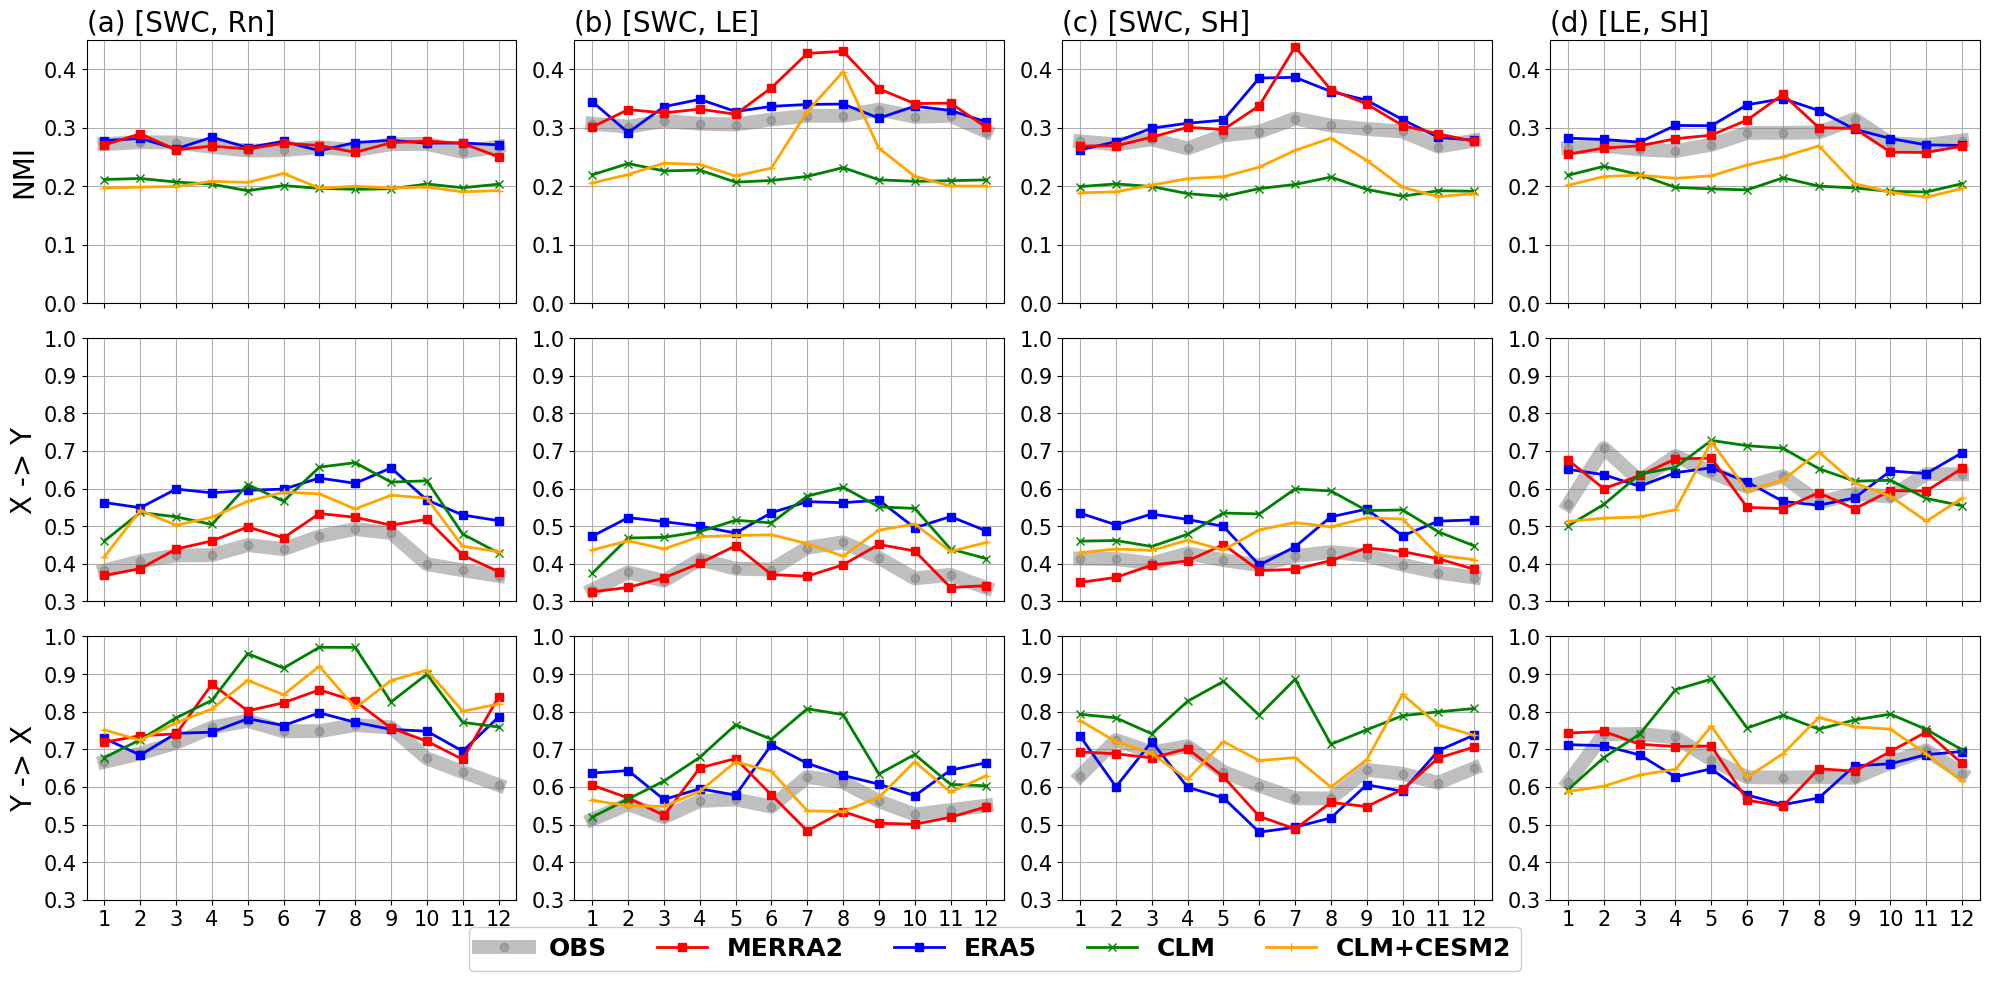

In [13]:
plot_TE_monthly_evolution(
    obs_nmi_summary   ,era_nmi_summary   ,merra_nmi_summary   ,clm_nmi_summary   ,amip_nmi_summary,
    obs_te_x_y_summary,era_te_x_y_summary,merra_te_x_y_summary,clm_te_x_y_summary,amip_te_x_y_summary,
    obs_te_y_x_summary,era_te_y_x_summary,merra_te_y_x_summary,clm_te_y_x_summary,amip_te_y_x_summary
)
